# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [ ]:
import pandas as pd
from os import chdir, listdir
import zipfile
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
# Code from: https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

# Get zip file from Github URL
!wget --no-check-certificate \
    "https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip" \
    -O "/tmp/pawpularity_data.zip"

# Opens the zip file in read mode and extract files into /tmp folder
zip_ref = zipfile.ZipFile('/tmp/pawpularity_data.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-01-13 10:16:21--  https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main [following]
--2022-01-13 10:16:22--  https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/pawpularity_data.zip’

/tmp/pawpularity_da     [            <=>     ] 984.17M  17.6MB/s    in 51s     

2022-01-13 10:17:13 (19.4 MB/s) - ‘/tmp/pawpularity_data.zip’ saved [1031974136]



In [ ]:
# Import the CSV tables
csv_train_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# Drop rows with missing values (if NaN values are in dataframe)
# No missing values present, so no samples dropped
csv_train_data.dropna()

# Scale the pawpularity score to numbers between 0 and 1
csv_train_data['Pawpularity'] = csv_train_data['Pawpularity'] / 100
sample_submission['Pawpularity'] = sample_submission['Pawpularity'] / 100

In [ ]:
csv_train_data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,0.42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,0.28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,0.15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,0.72


# Import image data


In [ ]:
def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    # Set the current path
    chdir(path)
    
    # Preset the lists
    images = []
    image_names = []
    
    # Go over all the files in the path
    for i in listdir():
        
        # Get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # Get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # Rescale the pixels and store in the list
        images.append(file/255)
        
    return images, image_names

# Reshape train and test images
train_imgs, train_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test", 64)

In [ ]:
# Make numpy arrays of images
train_imgs_array = np.array(train_imgs)
test_imgs_array = np.array(test_imgs)

# Combine tabular data with images

In [ ]:
def sort_dataframe(data, images, names):
    """
    This function sorts the dataframe of the csv data according to the image names.
    """
    data_sorted = pd.DataFrame()

    # Iterate over images and get index of each image
    for img, name in zip(images, names):
        location = data[data['Id'] == name].index[0]

        # Sort dataframe according to index of images
        data_sorted = data_sorted.append([data.loc[location]])
        
    return data_sorted

# Sort training and testing data
train_data_sorted = sort_dataframe(csv_train_data, train_imgs, train_names)
test_data_sorted = sort_dataframe(csv_test_data, test_imgs, test_names)
sample_submission_sorted = sort_dataframe(sample_submission, test_imgs, test_names)

# Processing tabular data

In [ ]:
# Select x-values (the 12 input features) from training data
x_train_tabular = train_data_sorted.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from training data
y_train = train_data_sorted.iloc[:,13].to_numpy()

# Select x-values (12 input features) from testing data
x_test_tabular = test_data_sorted.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from testing data
y_test = sample_submission_sorted.iloc[:,1].to_numpy()

In [ ]:
def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of 
    hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create a hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))
    
    # Create a hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu'))

    # Create the output layer with 1 regression output unit
    model.add(layers.Dense(units=1))
    
    return model

# Create neural network for tabular data and get summary of model 
# with 12 inputs and 100 hidden nodes
tabular_NN = build_neural_net(12, 100)
tabular_NN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               1300      
                                                                 
 dense_61 (Dense)            (None, 100)               10100     
                                                                 
 dense_62 (Dense)            (None, 1)                 101       
                                                                 
Total params: 11,501
Trainable params: 11,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_convol_net(image_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number 
    of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()
    
    # Create a convolutional layer with relu activation
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=image_size, padding='same'))
    
    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    
    # Create a convolutional layer with relu activation
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))

    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))

    # Create a convolutional layer with relu activation
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    
    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    
    # Create a flattening layer
    model.add(layers.Flatten())

    # Create a dense layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu'))

    # Create a dense layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))
    
    # Create the output layer with 1 sigmoid output unit
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [ ]:
# Create neural network for image data and get summary of model
image_size = (64, 64, 3)
image_NN = build_convol_net(image_size, hidden_nodes=100)
image_NN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 256)      

## Concatenate tabular and image data models

In [ ]:
def concatenate_models(model1, model2, hidden_nodes):
    """
    Concatenate two neural network models, model1 and model2, and create
    a concatenated model with dense layers with some hidden nodes.
    """
    # Input for concatenated model is retrieved by concatenating the output
    # of both models
    concat_input = layers.concatenate([model1.output, model2.output])

    # Create hidden layers of the concatenated model
    hidden_layer_1 = layers.Dense(hidden_nodes, activation="relu")(concat_input)
    hidden_layer_2 = layers.Dense(hidden_nodes, activation="relu")(hidden_layer_1)
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer_2)

    # Create concatenated model with inputs of both models and output of the
    # concatenated model
    concat_model = models.Model(inputs=[model1.input, model2.input], outputs=output_layer)

    return concat_model

Epoch 1/40
446/446 [==============================] - 5s 9ms/step - loss: 0.0432 - val_loss: 0.0410
Epoch 2/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0428 - val_loss: 0.0410
Epoch 3/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0426 - val_loss: 0.0409
Epoch 4/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0426 - val_loss: 0.0416
Epoch 5/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0425 - val_loss: 0.0410
Epoch 6/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0425 - val_loss: 0.0409
Epoch 7/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0425 - val_loss: 0.0410
Epoch 8/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0425 - val_loss: 0.0414
Epoch 9/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0425 - val_loss: 0.0410
Epoch 10/40
446/446 [==============================] - 4s 9ms/step - loss: 0.0424 - val_loss: 0.0411

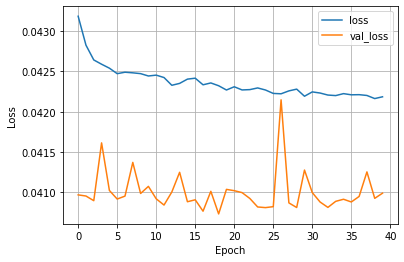

In [ ]:
# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Concatenate tabular and image neural networks
concat_model = concatenate_models(tabular_NN, image_NN, hidden_nodes=100)

# Compile model and use mean squared error as loss
concat_model.compile(loss=MeanSquaredError())

# Train the model by fitting both tabular and image data at the same time
history = concat_model.fit(x=[x_train_tabular, train_imgs_array], y=y_train, batch_size=20, epochs=40, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Plot loss during training of concatenated model
plot_loss(history)

# See how the model scored
loss = concat_model.evaluate(x=[x_test_tabular, test_imgs_array], y=y_test)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')